## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#append path with python modules
import importlib
import sys
sys.path.append("../modules")
#sys.path.append("/home/akalinow/scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Dane w postaci pary macierzy `x,y` są mało wydajne w sytuacji gdy jest ich dużo lub są rozmieszczone w wielu plikach.
TF dostarcza dedykowaną klasę do obsługi strumienia wejścia:
```Python
tf.data.Dataset(variant_tensor)
```

Klasa `tf.Dataset` pozwala na zaawansowane operacje na danych. Implementacja tych operacji korzysta równoległego przetwarzania danych w celu zwiększenia przepustowości strumienia wejścia: `liczby przykładów na sekundę`.



Obiekt `tf.Dataset` można tworzyć na wiele sposobów:

* z macierzy:

```Python
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
```

* z funkcji typu generator

```Python
dataset = tf.data.Dataset.from_generator(...)
```

* z pliku typu CSV

```Python
dataset = tf.data.TextLineDataset(...)
```

* z pliku zawierającego dane w dedykowanym formacie `TFRecord`

```Python
dataset = tf.data.TFRecordDataset(["file1.tfrecords", "file2.tfrecords"])
```



Konstrukcja `tf.data.Dataset` z macierzy NumPy

In [2]:
nExamples = 5
nFeatures = 3
epsilon = 0.01
x = tf.random.uniform((nExamples, nFeatures), minval=-1, maxval=1, dtype=tf.float32, name="features")
y = tf.math.reduce_sum(x**2, axis=1)
y = tf.reshape(y, (-1, 1))

print(colored("Features shape:", "blue"), x.shape)
print(colored("Labels shape:", "blue"), y.shape)

dataset = tf.data.Dataset.from_tensor_slices((x, y))
print(dataset)
print(colored("Dataset lenght:", "blue"), len(dataset))

Features shape: (5, 3)
Labels shape: (5, 1)
<_TensorSliceDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>
Dataset lenght: 5


`tf.Dataset` zachowuje się jak kolekcja - można po niej iterować łatwo dostosowując liczbę analizowanych elementów i punkt startowy:

In [3]:
print(colored("Iteration over the full dataset", "blue"))
for item in dataset:
    print(item)

print(colored("Iteration over n elements", "blue"))
n = 3
for item in dataset.take(n):
    print(item)

print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item)    

Iteration over the full dataset
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.8185208, 0.9667666, 0.9556935], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.517964], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.8910577 ,  0.49309015, -0.24522448], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0972568], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.30088592, 0.803627  , 0.13474774], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7545057], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.8022952 ,  0.21689296, -0.0390892 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6922481], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.30506063,  0.18842411,  0.7110982 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.63422626], dtype=float32)>)
Iteration over n eleme

2024-04-04 09:50:22.109815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 09:50:22.115413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 09:50:22.256870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Konstrukcja `tf.Dataset` z funkcji generującej.

W tym wypadku oprócz funkcji generującej musimy podać informacje o kształcie i typie danych generowanych przez funkcję:
```Python
dataset = tf.data.Dataset.from_generator(
         generator,                                      # funkcja generująca
         output_signature=(                              # opis kształtu i typu
             (tf.TensorSpec(shape=(3), dtype=tf.float32),# danych generowanych
             tf.TensorSpec(shape=(1), dtype=tf.int32)))  # przez funkcję
    )
```

In [4]:
#Generator function definition
nFeatures = 3

def points3DGenerator():
    while True:
        x = tf.random.uniform(shape=(nFeatures,), minval=0.1, maxval=1, dtype=tf.float32, name="features")
        y = tf.math.reduce_sum(x**2, axis=0)
        y = tf.reshape(y, (1))
        yield x,y

#Dataset from generator
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )


In [5]:
print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item) 

Iteration over n elements starting from m
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7915454 , 0.76446   , 0.79162294], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.8376101], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.2373822 , 0.9259607 , 0.15527883], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9378651], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.38022003, 0.12676361, 0.34600696], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2803571], dtype=float32)>)


2024-04-04 09:50:22.402872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Na zbiorze `tf.Dataset` można wykonywać różne operacje przekształcenia:

```Python
dataset = dataset.repeat(n) - # powtarza dane n razy
                              # W sytuacji gdy nie podano argumentu
                              # dane są powtarzane w nieskończoność.
```

**Uwaga:** nie trzeba używać `repeat` by uzyskać wiele epok w czasie treningu. Funkcja `model.fit(...)` 
sama zarządza wielokrotnymi przejściami przez zbiór danych

```Python
dataset = dataset.batch(n)   - # grupowanie zbioru w paczki. 
                               # W czasie treningu paczki są automatycznie 
                               # rozpoznane i nie trzeba (nie wolno) podawać 
                               # rozmiaru paczki explicite. 
```

```Python
dataset = dataset.skip(m)    - # opuszcza pierwsze m przykładów
                              
```

```Python
dataset = dataset.take(n)    - # ogranicza zbiór do pierwszych n przykładów
                              
```

```Python
dataset = dataset.skip(m).take(n)    - # opuszcza pierwsze m, i bierze 
                                       # kolejne n przykładów
                              
```

In [6]:
dataset_batched = dataset.batch(2)

#Access a single example (batch in this case)
it = iter(dataset_batched)
print(colored("Features shape:", "blue"), next(it)[0].numpy().shape)
print(colored("Labels shape:", "blue"), next(it)[1].numpy().shape)

print(colored("Iteration over n elements starting from m", "blue"))
n = 1
for item in dataset_batched.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Features shape: (2, 3)
Labels shape: (2, 1)
Iteration over n elements starting from m
	Labels: [[0.35762605 0.7846036  0.93214524]
 [0.56599915 0.5002504  0.43229628]]
	Features: [[1.6123939 ]
 [0.75748557]]


2024-04-04 09:50:22.561823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Zbiór danych można poddać też ogólnej transformacji zmieniającej zawartość poszczególnych wierszy:
```Python
dataset_transformed = dataset.map(func) # func to funkcja przyjmująca dany wiersz i zwracająca nowy
```

In [7]:
def func(features, label):
    return features**2, label

dataset_transformed = dataset.map(func)

print(colored("Iteration over original dataset", "blue"))
for item in dataset.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

print(colored("Iteration over transformed dataset", "blue"))
for item in dataset_transformed.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Iteration over original dataset
	Labels: [0.34646636 0.34010264 0.81056136]
	Features: [0.89271843]
Iteration over transformed dataset
	Labels: [0.558791   0.09244452 0.15289152]
	Features: [0.80412704]


2024-04-04 09:50:22.614295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 09:50:22.668474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* skopiować funkcję `discGenerator` z poprzednich zajęć
* stworzyć zbiór `tf.Dataset` obrazów kół korzystając bezpośrednio z generatora. Proszę przyjąć rozdzielczość 256 $\times$ 256

In [8]:
#BEGIN_SOLUTION
res = 256

def discGenerator():

    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label

dataset = tf.data.Dataset.from_generator(discGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(3), dtype=tf.int32),
             tf.TensorSpec(shape=(res,res,1), dtype=tf.int32)))
    )
#END_SOLUTION

item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (3,)
Labels shape: (256, 256, 1)


**Proszę:**

* napisać funkcję `reading_benchmark(dataset)` która przyjmuje zbiór danych, iteruje po całym zbiorze i oblicza i 
   wypisuje na ekran swój czas wykonania
* w iteracjach po elementach zbioru proszę wstawić krótki postój:
```Python
time.sleep(1E-10)
```
* proszę wywołać funkcję na zbiorze który ma $10^{4}$ elementów i zarejestrować czas przebiegu po zbiorze

In [9]:
import time

def reading_benchmark(dataset):
#BEGIN_SOLUTION 
    start_time = time.perf_counter()
    for sample in dataset:
        # Performing a training step
        time.sleep(1E-10)
    tf.print("Execution time: {:3.2f} s".format(time.perf_counter() - start_time))


reading_benchmark(dataset.take(int(1E4)))    
#END_SOLUTION    

Execution time: 12.70 s


2024-04-04 09:50:35.502076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generacja danych za każdym razem kiedy jest wywoływana iteracja po zbiorze jest kosztowana - 
lepiej wygenerować dane raz i je zapisać w pamięci podręcznej. To samo dotyczy zbiorów czytanych z dysku i 
poddawanych kosztownym operacjom przekształcania. Zapisywanie zbioru w tymczasowym pliku można uzyskać przez metodę `cache`:
```Python
dataset_cached = dataset.cache()
```

**Proszę:**

* wywołać dwa razy funkcję `reading_benchmark` na zbiorze `dataset_cached`
* czy jest jakaś różnica w czasie wykonania?
* jeśli tak, to skąd się ona bierze?

In [10]:
#BEGIN_SOLUTION
dataset_cached = dataset.take(int(1E4)).cache()

print(colored("First pass", "blue"))
reading_benchmark(dataset_cached)
print(colored("Second pass", "blue"))
reading_benchmark(dataset_cached)
#END_SOLUTION

First pass
Execution time: 13.64 s


2024-04-04 09:50:49.195460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Second pass
Execution time: 1.94 s


2024-04-04 09:50:51.139622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Każdy wiersz danych w postaci `tf.Dataset` powinien zawierać cechy i etykiety by można go było przekazać do funkcji trenującej model:
```Python
model.fit(dataset, ...)  #Podajemy tylko tf.Dataset. 
                         #Metoda model.fit(...) sama rozkłada każdy wiersz na cechy i etykiety
```

Jeśli `tf.Dataset` pochodzi z generatora, jako dane walidacyjne najlepiej podać nowy zbiór. 
W tej sytuacji trzeba także podać liczbę przykładów dla obu zbiorów:

```Python
model.fit(dataset.batch(batchSize).take(nStepsPerEpoch),
          epochs=nEpochs, 
          validation_data=dataset.batch(batchSize).map(mapFunc).take(100))
```

**Proszę:**

* wytrenować **minimalny** model obliczający kwadrat odległości punktu od środka układu współrzędnych
* jako zbiorów uczacego, walidacyjnego i testowego proszę użyć obiektów `tf.Dataset` wypełnionych z użyciem generatora `points3DGenerator(...)`
* użyć funkcji przekształcającej etykietę do wymaganej postaci
* przyjąć następujące parametry treningu:
```Python
nEpochs = 5
nStepsPerEpoch = 4096
batchSize = 32
initial_learning_rate = 5E-2
```
* narysować historię treningu
* obliczyć ułamek przykładów ze zbioru testowego dla którego wynik modelu różni się od etykiety o nie więcej niż 1%

**Wskazówka:**
wartości etykiet można wydobyć w następujący (suboptymalny) sposób:
```Python
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])
```

**Uwaga:** trening powinien zająć około 3'

Czy wynik na zbiorze testowym jest zgodny z oczekiwaniem?

Epoch 1/5


I0000 00:00:1712224262.455227  274612 service.cc:145] XLA service 0x7efe60006080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712224262.455245  274612 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1712224262.455246  274612 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5


      9/Unknown 12s 20ms/step - loss: 65.4372

I0000 00:00:1712224262.683897  274612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   3840/Unknown 181s 44ms/step - loss: 2.5209

2024-04-04 09:53:51.808446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:51.808474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 181s 44ms/step - loss: 2.5205 - val_loss: 0.9203
Epoch 2/5
 322/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.6643

2024-04-04 09:53:52.109187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:52.109214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step - loss: 0.8262 - val_loss: 0.8745
Epoch 3/5
 112/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.7742

2024-04-04 09:53:53.890715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:53.890737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-04 09:53:54.015490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:54.015514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - loss: 0.8694 - val_loss: 0.6791
Epoch 4/5
  98/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - loss: 0.8599

2024-04-04 09:53:55.728266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:55.728287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-04 09:53:55.849542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:55.849563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 505us/step - loss: 0.8272 - val_loss: 1.0329
Epoch 5/5
  94/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 544us/step - loss: 0.6508

2024-04-04 09:53:57.684447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:57.684470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-04 09:53:57.791595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:57.791618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 517us/step - loss: 0.8000 - val_loss: 0.2284
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.2705


2024-04-04 09:53:59.664393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:59.664416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-04 09:53:59.781988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:59.782011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-04 09:53:59.803745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 09:53:59.803768: W 

Model weights:
output: [1.0016797 1.0011911 1.0053968]
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


2024-04-04 09:54:03.224383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fraction of examples with abs(pull)<0.01: 0.01
Pull standard deviation: 1.47
CPU times: user 3min 13s, sys: 9.93 s, total: 3min 23s
Wall time: 3min 15s


2024-04-04 09:54:06.314091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


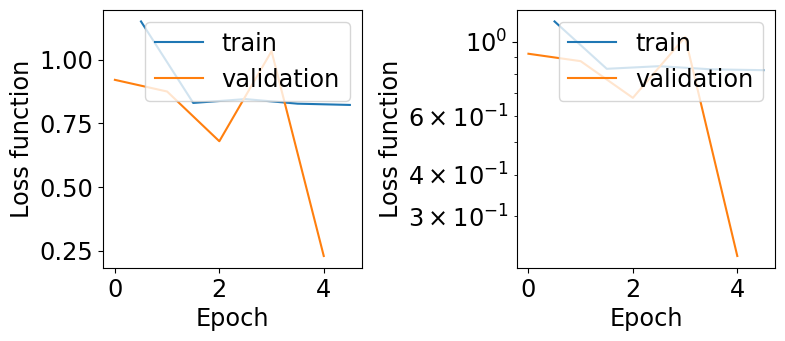

In [11]:
%%time
#Dataset from generator
##BEGIN_SOLUTION
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )
##END_SOLUTION

#Model definition
#BEGIN_SOLUTION
def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):
   
    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = inputs
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                                  name="layer_"+str(iLayer))(x)
                
    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)   
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model
#END_SOLUTION
#################
#Model training
#BEGIN_SOLUTION
nEpochs = 5
nStepsPerEpoch = 4096
batchSize = 64

initial_learning_rate = 5E-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*3,
                decay_rate=0.95,
                staircase=True)

model = getModel(inputShape=(nFeatures,), nNeurons = np.array([]), 
                 hiddenActivation="relu", 
                 outputActivation="linear", 
                 nOutputNeurons=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.MeanAbsolutePercentageError(),
            metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=1E-3)
callbacks = [early_stop_callback]
    
dataset_cached = dataset.batch(batchSize).map(func).take(nStepsPerEpoch).cache()
history = model.fit(dataset_cached.skip(batchSize*4),
                    epochs=nEpochs, 
                    validation_data=dataset_cached.take(batchSize*4),
                    callbacks=callbacks,
                    verbose=1)

model.evaluate(dataset_cached.take(16))
plf.plotTrainHistory(history)

print(colored("Model weights:","blue"))
print(colored("output:","blue"), model.get_layer('output').weights[0].numpy()[:,0])
#END_SOLUTION
#################
#Model evaluation
dataset_test = dataset.batch(128).map(func).take(16)
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.2f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))

**Proszę:**

* rozwiązać problem z różnicą wyników na zbiorach treningowym i testowym
* narysować histogram różnicy względnej:

$$
{\huge
\mathrm{pull} = \frac{\mathrm{model} - \mathrm{true}}{\mathrm{true}}
}
$$

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


2024-04-04 10:17:08.041066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.2240


2024-04-04 10:17:08.612875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 10:17:08.682753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-04 10:17:08.682776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


Fraction of examples with abs(pull)<0.01: 0.9666
Pull standard deviation: 0.0041


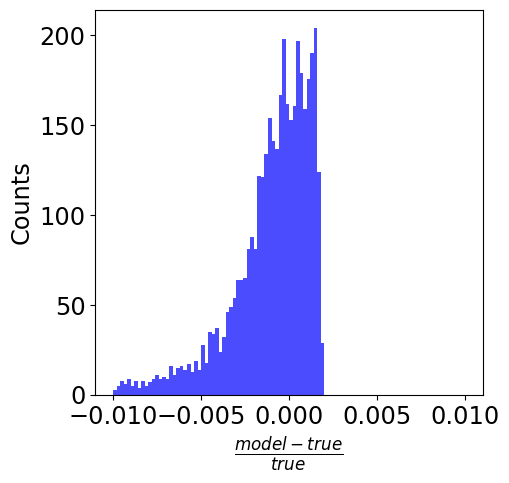

In [19]:
#BEGIN_SOLUTION
dataset_test = dataset.batch(128).map(func).take(32).cache()
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

fig, axis = plt.subplots(1,1, figsize=(5, 5))
axis.hist(pull, bins=100, range=(-0.01, 0.01), color='b', alpha=0.7, label='Pull');
axis.set_xlabel(r'$\frac{model-true}{true}$')
axis.set_ylabel('Counts')
model.evaluate(dataset_test)
print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.4f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.4f}".format(pull.std()))
#END_SOLUTION

## Zbiory danych w TensorFlow datasets

Środowisko TensorFlow dostarcza wygodnego iterfejsu użytkownika do dostępu do publicznych zbiorów danych (podobnie jak inne pakiety):
[TensorFlow Datasets](https://www.tensorflow.org/datasets).


In [21]:
import tensorflow_datasets as tfds

#Create a dataset builder object
mnist_builder = tfds.builder('mnist')

#Download the dataset as a dictionary of tf.data.Datasets
data_dir = "/home/akalinow/scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/tensorflow_datasets/"
data_dir = "../data/tensorflow_datasets/"

datasets, ds_info = tfds.load("mnist", 
                              data_dir = data_dir,
                              with_info=True)

#Download the dataset as a tuple of tf.data.Datasets
#datasets, ds_info = tfds.load("mnist", as_supervised=True, with_info=True)

# Load data from disk as tf.data.Datasets
train_dataset, test_dataset = datasets['train'], datasets['test']

# Fetch the first batch of the dataset
item = next(iter(train_dataset.batch(16)))

print(colored("Features shape:", "blue"), item['image'].shape)
print(colored("Labels shape:", "blue"), item['label'].shape)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ../../data/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Features shape: (16, 28, 28, 1)
Labels shape: (16,)


2024-04-04 10:18:30.115501: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Biblioteka `tensorflow_datasets` dostarcza użytecznej funkcji do testu  wydajności wczytytywania zbioru danych:

```Python
tfds.benchmark(train_dataset, # Obiekt który dostarcza interfejsu iteratora
                batch_size)   # Liczba służąca do normalizacji liczby wczytanych przykładów. 
                              # Podział na paczki trzeba ustawić na zbiorze explicite.
```

**Proszę:**

* uruchomić dwukrotnie test wydajności na zbiorze MNIST wczytanym z użyciem modułu `tensorflow_datasets` dla paczki o rozmiarze `32`

In [22]:
#BEGIN_SOLUTION
batchSize = 32
train_dataset_batched = train_dataset.batch(batchSize)

tfds.benchmark(train_dataset_batched, batch_size=batchSize)
tfds.benchmark(train_dataset_batched, batch_size=batchSize)
#END_SOLUTION
pass


************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 137504.58 ex/sec (total: 60032 ex, 0.44 sec)
Examples/sec (First only) 655.27 ex/sec (total: 32 ex, 0.05 sec)
Examples/sec (First excluded) 154740.22 ex/sec (total: 60000 ex, 0.39 sec)

************ Summary ************



2024-04-04 10:18:48.467046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 274523.16 ex/sec (total: 60032 ex, 0.22 sec)
Examples/sec (First only) 2465.31 ex/sec (total: 32 ex, 0.01 sec)
Examples/sec (First excluded) 291690.87 ex/sec (total: 60000 ex, 0.21 sec)


2024-04-04 10:18:48.708203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Funkcja `tfds.show_examples(...)` pozwala na szybkie wyświetlenie przykładów z podanego zbioru.

**Uwaga:** funkcja wymaga obiektu `dataset_info.DatasetInfo`

2024-04-04 10:19:01.516911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


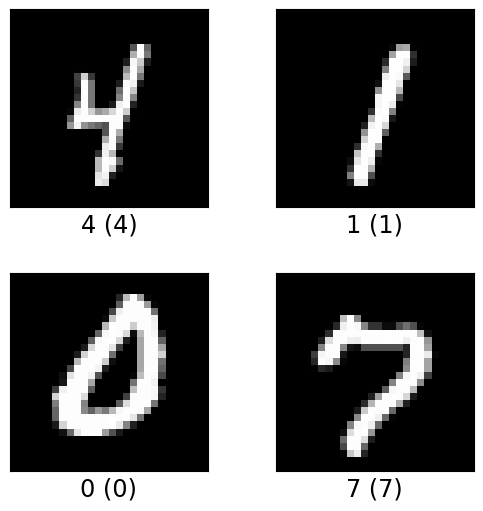

In [23]:
fig = tfds.show_examples(train_dataset, ds_info, rows=2, cols=2)

# Zadanie domowe

**Proszę:**

* napisać funkcję `load_wksf_dataset(filePath)`, wczytującą i wstępnie przetwarzającą  zbiór fragmentów tekstow w języku polskim: [link](https://drive.google.com/drive/folders/18vDJPEZd2C6_-TualBIhsR5zmbhDA00D?usp=drive_link) pochodzący ze [Wzbogaconego korpusu słownika frekwencyjnego polszczyzny współczesnej](https://clarin-pl.eu/dspace/handle/11321/715)
* funkcja powinna wykonywać następujące kroki:
  * wczytywanie wszystkich plików w katalogu podanym jako `filePath` do obiektu `tf.data.Dataset` 
  * przetwarza powstały obiekt by usunąć:
    * informację o źródle cytatu
    * odnośniki w tekście
    * fragmenty typu `[/]` 

* funkcję umieścić w pliku `text_functions.py`
 * uruchomić komórkę poniżej
 
**Wskazówka:**
* mozna użyć funkcji `tf.strings.regex_full_match(...)` oraz `tf.strings.regex_replace(...)` do filtrowania linii lub zastępowania
  fragmentów napisów
  

In [ ]:
import text_functions as txtfunc
importlib.reload(txtfunc)

filePath = "../data/wksf/Korpus_surowy/"
dataset = txtfunc.load_wksf_dataset(filePath)

for item in dataset.take(5):
    print(colored("Item:","blue"), end=" ")
    print(item.numpy().decode("utf-8"))


Sztuka utraciła swoją moc pobudzającą: przykrym widowiskiem staje się koncert wybitnej niegdyś śpiewaczki i nie uświetnią go nawet nigdy dotąd nie wykonywane utwory genialnego kompozytora. Słuchacze myślą o czym innym, rozmawiają o czym innym i śpiewaczka, postarzawszy się, głos straciła. Nie było dotąd takich koncertów u Iwaszkiewicza.
Stosunek tych dwóch rodzajów mieszczan układa się tak, że solidny obywatel uważa egzystencję poety czy malarza za mocno wątpliwą, podejrzaną: ten zaś rewanżuje się pogardą i krytycznym stanowiskiem wobec „nieartystycznego” przedstawiciela klasy, z której sam wyszedł (ta wzajemna nieufność i niechęć zaznacza się już zresztą w [„]Buddenbrookach[”] porównaj postać Gerdy).
Wzrasta w stosunku do całej puli eksportowej eksport drewna najwyższych gatunków i przetworów (meble, płyty pilśniowe), maleje eksport drewna surowca, natomiast rośnie import gatunków tanich, a w Polsce deficytowych. Tendencja zdrowa. Inwestycje w przemyśle towarzyszącym gospodarce leśnej

2024-04-04 10:21:00.076300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 10:21:00.151521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
